In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from google.colab import drive
import os
tqdm.pandas()

In [2]:
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Capstone_project/")

Mounted at /content/drive


# Load Data

In [70]:
def merge_dy_origin(train_dy, origin_data):
  train_dy_metrics_off = train_dy.merge(origin_data["offensiveYN"], left_on="guid", right_on=origin_data["offensiveYN"].index)
  train_dy_metrics_off["abs_offensiveYN"] = train_dy_metrics_off["offensiveYN"].apply(lambda x : round(abs(x-0.5),2))
  return train_dy_metrics_off

In [73]:
train_df = pd.read_csv("SBIC.v2.agg.trn.csv")
val_df = pd.read_csv("SBIC.v2.agg.dev.csv")

overall_train_dy = pd.read_csv("train_dy_metrics.csv")
overall_train_df = merge_dy_origin(overall_train_dy, train_df)

# KMeans clustering

In [74]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(overall_train_df[["confidence", "variability"]].values)
overall_train_df["label"] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


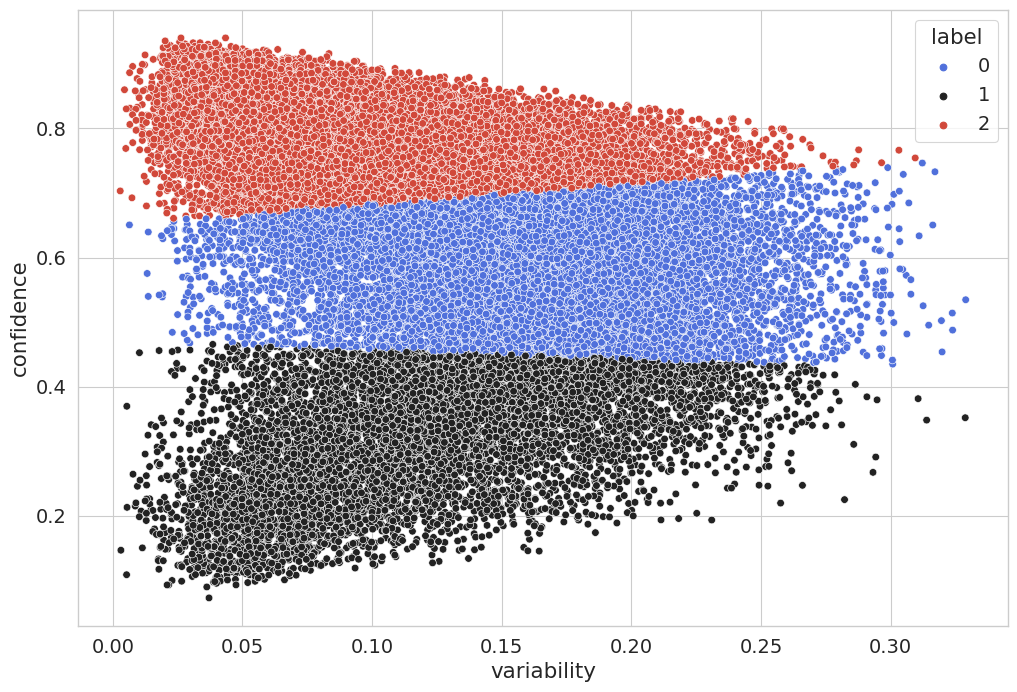

In [75]:
sns.set(style='whitegrid', font_scale=1.6, context='paper')

fig = plt.figure(figsize=(12, 8))
pal = sns.diverging_palette(260, 15, n=3, sep=10, center="dark")

sns.scatterplot(data=overall_train_df, x="variability", y="confidence", hue="label", palette=pal, s=30)
plt.show()

# Analysis

In [76]:
first_cluster = overall_train_df[overall_train_df["label"] == 0].reset_index(drop=True)
second_cluster = overall_train_df[overall_train_df["label"] == 1].reset_index(drop=True)
third_cluster = overall_train_df[overall_train_df["label"] == 2].reset_index(drop=True)

Number of data for each cluster, clutser 1 : 11656 , clutser 2 : 7208 , clutser 3 : 16560
[Average confidence / variability] clutser 1 : 0.5857/0.1605 , clutser 2 : 0.3153/0.1210 , clutser 3 : 0.7959/0.0940


In [165]:
data_list = [first_cluster, second_cluster, third_cluster]
highest_conf = 0
highest_var = 0

for i, data in enumerate(data_list):
  mean_conf = data["confidence"].mean()
  mean_var = data["variability"].mean()
  if highest_conf < mean_conf:
    easy = data
    highest_conf = mean_conf
    easy_ind = i
  if highest_var < mean_var:
    ambiguous = data
    highest_var = mean_var
    amb_ind = i
hard_ind = [ind for ind in [0,1,2] if ind not in [easy_ind] + [amb_ind]]
hard = data_list[hard_ind[0]]

print("Number of data for each cluster, easy : {} , ambiguous : {} , hard : {}".format(
    len(easy), len(ambiguous), len(hard)))
print("[Average confidence / variability] easy : {:.4f} / {:.4f} , ambiguous : {:.4f} / {:.4f} , hard : {:.4f} / {:.4f}".format(
    easy["confidence"].mean(),easy["variability"].mean(),ambiguous["confidence"].mean(),ambiguous["variability"].mean(),
    hard["confidence"].mean(),hard["variability"].mean()
))

Number of data for each cluster, easy : 16560 , ambiguous : 11656 , hard : 7208
[Average confidence / variability] easy : 0.7959 / 0.0940 , ambiguous : 0.5857 / 0.1605 , hard : 0.3153 / 0.1210


In [212]:
def plot_distribution(easy, ambiguous, hard):
  fig = plt.figure()
  fig.set_figheight(5)
  fig.set_figwidth(10)
  fig.tight_layout()
  plt.boxplot(x=[easy["abs_offensiveYN"], ambiguous["abs_offensiveYN"], hard["abs_offensiveYN"]])
  plt.xticks([1,2,3], ["easy", "ambiguous", "hard"])
  plt.ylabel("Agreement")
  fig, ax = plt.subplots(1, 3)
  fig.set_figheight(5)
  fig.set_figwidth(10)
  fig.tight_layout()
  sns.histplot(data=easy, x="abs_offensiveYN", ax=ax[0])
  ax[0].set_title("easy")
  sns.histplot(data=ambiguous, x="abs_offensiveYN", ax=ax[1])
  ax[1].set_title("ambiguous")
  sns.histplot(data=hard, x="abs_offensiveYN", ax=ax[2])
  ax[2].set_title("hard")
  plt.show()

def plot_corr_plot(easy_df, amb_df, hard_df):
  df_list = [easy_df, amb_df, hard_df]
  fig, ax = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(10)
  fig.tight_layout()
  ax[0].set_xlabel("Agreement Level")
  ax[0].set_title('Agreement - Confidence correlation')
  ax[1].set_xlabel("Agreement Level")
  ax[1].set_title('Agreement -Variability correlation')
  conf_list = []
  var_list = []
  for data in df_list:
    df = data.copy()
    med_value = df["abs_offensiveYN"].median()
    df["over_median_agreement"] = df["abs_offensiveYN"].apply(lambda x : 1 if x >= med_value else 0)
    confidence_data = df.groupby("over_median_agreement")["confidence"].apply(list).reset_index(name="confidence")
    var_data = df.groupby("over_median_agreement")["variability"].apply(list).reset_index(name="variability")
    conf_list += confidence_data["confidence"].tolist()
    var_list += var_data["variability"].tolist()

  ax[0].boxplot(conf_list)
  ax[1].boxplot(var_list)
  ax[0].tick_params(labelsize=5)
  ax[1].tick_params(labelsize=5)
  plt.setp(ax, xticks=[1,2,3,4,5,6], xticklabels=["below easy", "above easy", "below amb", "above amb", 
                                                  "below hard", "above mhard"])
  plt.show()

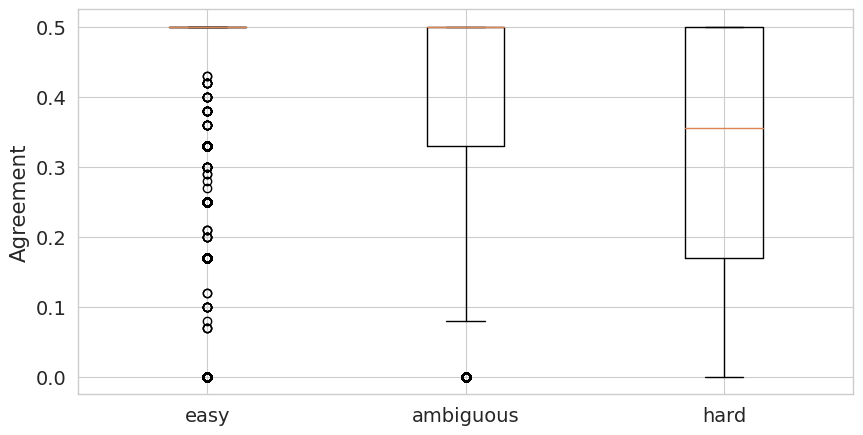

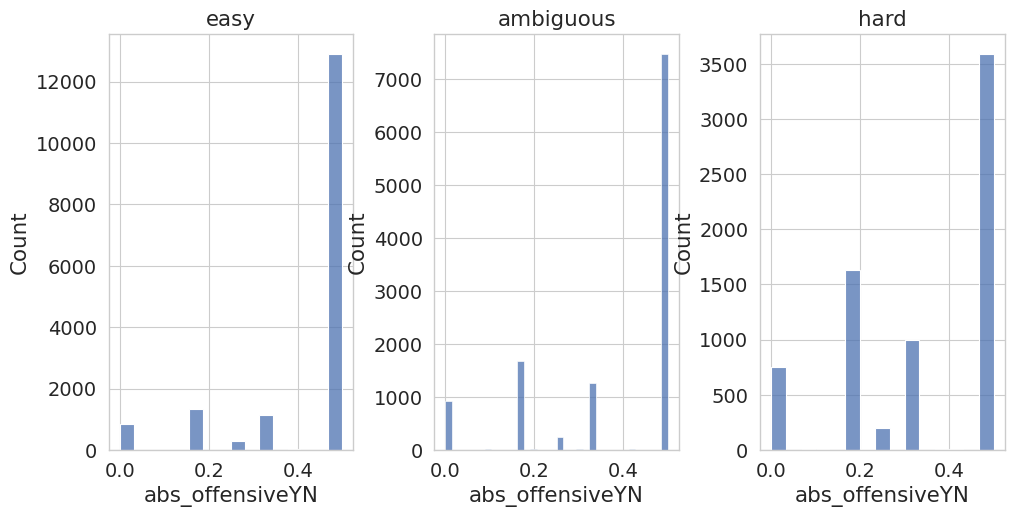

In [213]:
plot_distribution(easy, ambiguous, hard)

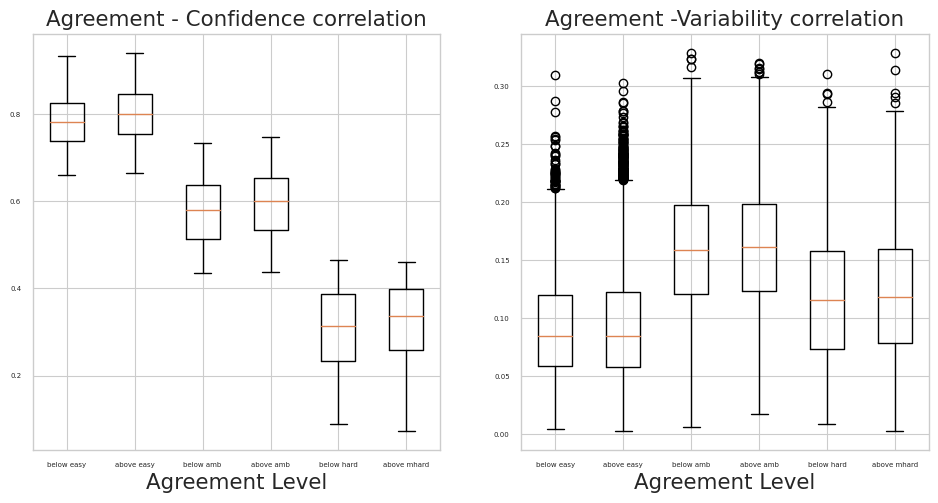

In [214]:
plot_corr_plot(easy, ambiguous, hard)